# Specific Clause Investigation: Audit Rights

In [14]:
#Import required packages
from DownloadCUAD import DownloadCUAD
from UsefulProjectFunctions import print_class_samples, write_vector

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS# Generate word cloud
import re
import string

from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import AgglomerativeClustering

import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RichardWarburton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Section 1: Download Data

In [15]:
#Download CUAD Data to local drive
DC = DownloadCUAD()
DC.setup()

CUAD data downloading...
CUAD data downloaded & extracted!


In [16]:
#Extract annotations for specific clause and the coresponding contracts 
clause_of_interest = 'Audit Rights'

#Concatenate string where there are multiple annotations.
contracts,combined_annotations = DC.extract_clause(clause_of_interest,True)

There are 214 contracts with 'Audit Rights' annotations
There are 136 contracts with more than one annotation


In [17]:
combined_annotations = np.array(list(map(lambda x: re.sub('\\t|\\r|\\n|[^\S]{2,}',' ',x),combined_annotations)))
combined_annotations = np.array(list(map(lambda x: x.translate(str.maketrans('', '', string.punctuation)),combined_annotations)))


## Section 2: Vectorizing The Clause Data

In [18]:
#Force to lower case
combined_annotations = np.array(list(map(lambda x: x.lower(),combined_annotations)))

### 2.1: Simple TFIDF Vectorisation Of The Clause

The approach here will be to apply a TDIF vectorisation to the whole clause text (with stop words removed)and see if we are able to spot any patterns emerge when we plot the resulting feature space in 2D using a TSNE plot.  A range of maximum features (5,15,30,50) and n grams ((1,2),(1,3),(1,4) will be used in this investigation. 

In [6]:
#Define stopwords list
stop_words = stopwords.words('english') +['audit','audeted','auditing','rights',
                                          'right','business','inspect','records','party']

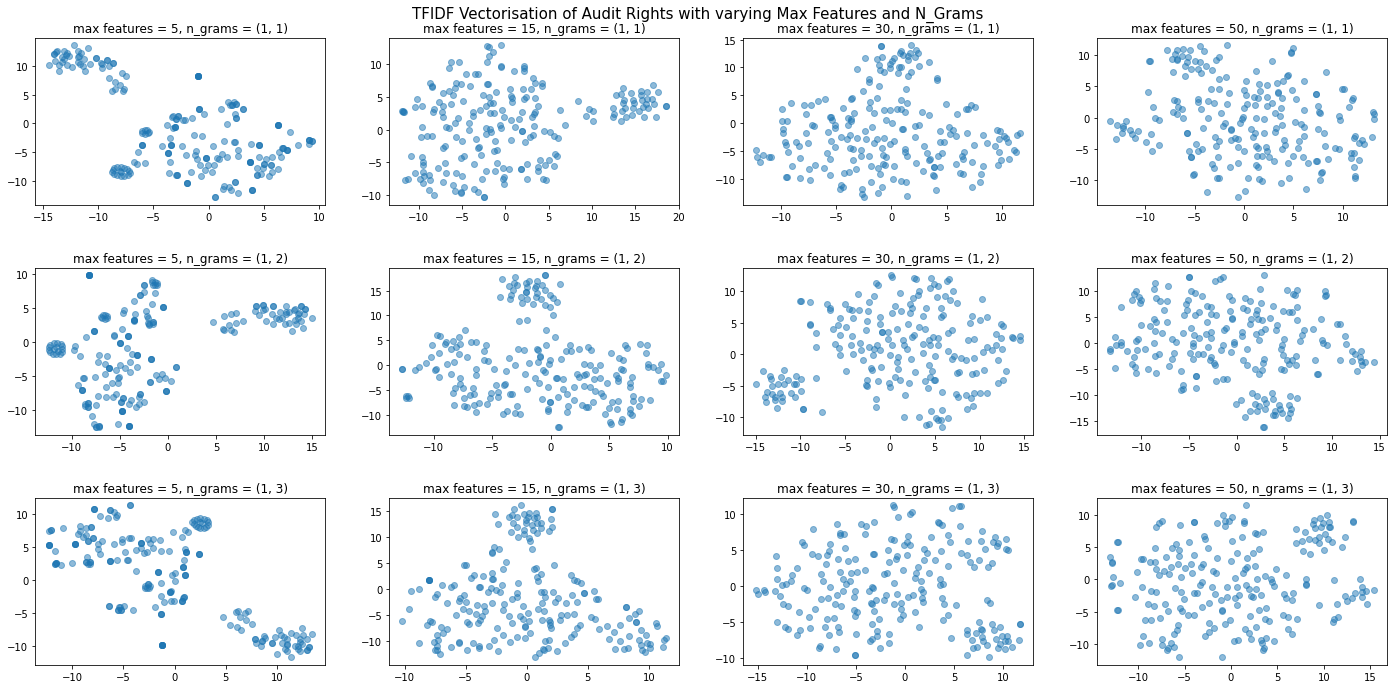

In [7]:
#Define max feature and n_gram ranges
max_features = [5,15,30,50]
n_grams = [(1,1),(1,2),(1,3)]

#Initate plot
fig, axs = plt.subplots(len(n_grams),len(max_features), figsize = (20,10))

#For each pair of max_features and n_grams
for i in range(len(max_features)):
  for j in range(len(n_grams)):

    #TFIDF vectorize the annotation
    vectorizer = TfidfVectorizer(ngram_range = n_grams[j],stop_words = stop_words,max_features=max_features[i])
    X = vectorizer.fit_transform(combined_annotations).toarray()  

    #Reduce dimension wiht TSNE to 2D
    X_tsne = TSNE(n_components=2).fit_transform(X)
    x = X_tsne[:,0]
    y = X_tsne[:,1]

    #Plot respective parameters
    axs[j,i].scatter(x, y, alpha = 0.5)
    axs[j,i].set_title('max features = {}, n_grams = {}'.format(*(max_features[i],n_grams[j])))

#Format plot
plt.tight_layout(pad=3.0)
plt.suptitle('TFIDF Vectorisation of {} with varying Max Features and N_Grams\n\n'.format(clause_of_interest),size = 15)
plt.show()

We see quite a pronounced clustering appear with two distinct classes at max_features = 30 and 5 across all n grams

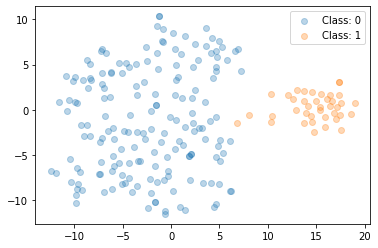

In [8]:
selected_max_features = 15
selected_n_gram = (1,2)
n_clusters = 2

vectorizer = TfidfVectorizer(ngram_range = selected_n_gram,stop_words =stop_words,max_features=selected_max_features)
X = vectorizer.fit_transform(combined_annotations).toarray()  

#Reduce dimension wiht TSNE to 2D
X_tsne = TSNE(n_components=2).fit_transform(X)

#Fit agglomerative clister model with two clusters to split groups
cluster = AgglomerativeClustering(n_clusters = n_clusters).fit(X_tsne)

x = X_tsne[:,0]
y = X_tsne[:,1]
labels = cluster.labels_

for i in np.unique(labels):
  idx = labels == i
  plt.scatter(x[idx],y[idx],label = 'Class: {}'.format(str(i)),alpha = 0.3)

plt.legend(bbox_to_anchor = (1,1))
plt.show()

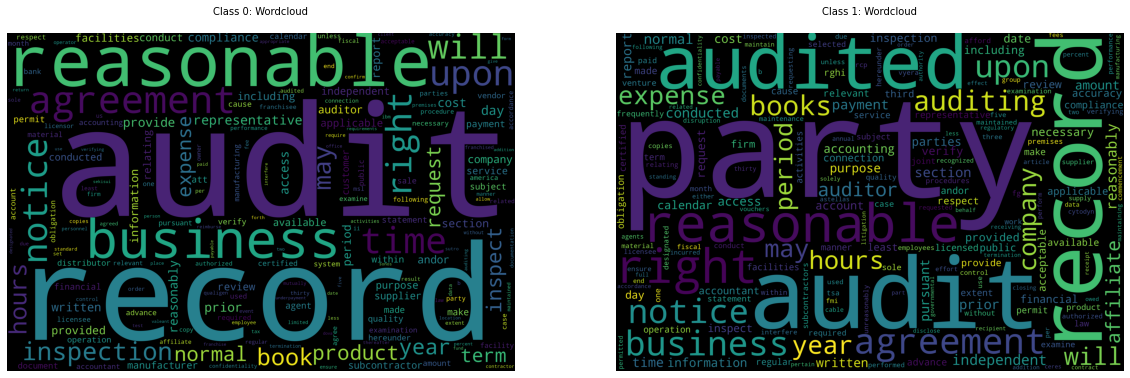

In [9]:
classes = np.unique(labels)
num_classes = np.unique(labels).shape[0]

fig, axs = plt.subplots(1,num_classes, figsize = (20,10))

for cl in classes:
    text = ' '.join(combined_annotations[labels==cl])
    wordcloud = WordCloud(width = 3000, height = 2000, random_state=1,collocations=False, stopwords = STOPWORDS).generate(text)# Plot
    
    #plot wordcloud
    axs[cl].imshow(wordcloud)
    axs[cl].set_title('Class {}: Wordcloud\n'.format(str(cl)),size = 10)
    axs[cl].axis('off')

plt.show()

In [10]:
class_vocab_count = defaultdict(list)
vocab = vectorizer.vocabulary_

for i in np.unique(labels):
    idx = labels == i
    class_annotations = combined_annotations[idx]
    
    for annotation in class_annotations:
        for word in vocab:
            if word in annotation:
                class_vocab_count[i].append(word)


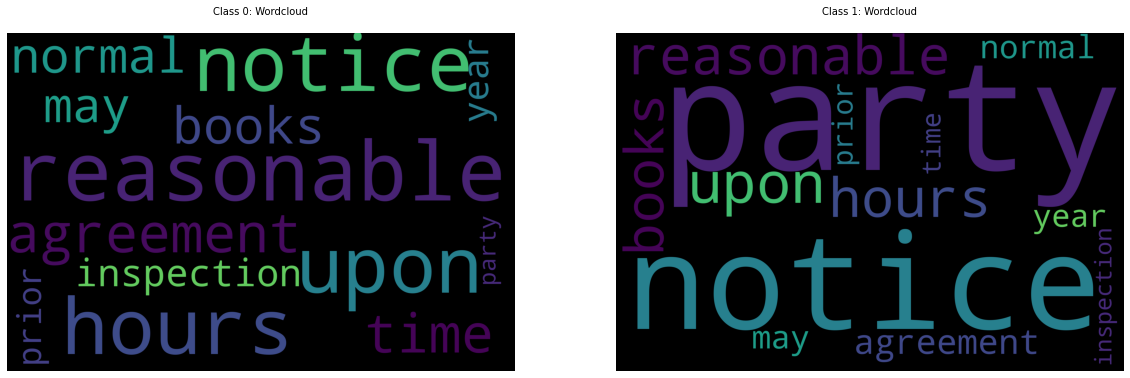

In [11]:
classes = np.unique(labels)
num_classes = np.unique(labels).shape[0]

fig, axs = plt.subplots(1,num_classes, figsize = (20,10))

for cl in classes:
    text = ' '.join(class_vocab_count[cl])
    wordcloud = WordCloud(width = 3000, height = 2000, random_state=1,collocations=False, stopwords = STOPWORDS).generate(text)# Plot
    
    #plot wordcloud
    axs[cl].imshow(wordcloud)
    axs[cl].set_title('Class {}: Wordcloud\n'.format(str(cl)),size = 10)
    axs[cl].axis('off')

plt.show()

In [12]:
print_class_samples(combined_annotations,labels,n_rnd=5)

CLASS 0

dd shall also make its records and other documents relevant to mbrk and this agreement available for audit or review by mbrk upon mbrks request at a mutually agreed upon time
----- 

mbe will also permit the company to enter any of mbes premises during regular business hours to inspect the use of the service in any reasonable manner mbe shall at any time during the term of this agreement be entitled to audit all such records upon ten 10 days written notice to the company in order to confirm the accuracy of such records and conformance with the terms and conditions of this agreement provided however that no more than one 1 such audit may be conducted in any ninety 90day period
----- 

the audit will be conducted at the expense of pretzel time provided that if an audit disclosed an understatement of two percent 2 as described above franchisee will bear the cost of the audit including without limitation the charges of attorneys and any independent accountants their travel expense

## Output Vectorization

In [13]:
write_vector(list(contracts),list(map(list,X)),clause_of_interest)